In [1]:
#Importing the libraries

import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


In [2]:
%config Completer.use_jedi = False

In [3]:
#Getting the datset

prices_df = pd.read_csv('train.csv')
prices_df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [4]:
#pp.ProfileReport(prices_df)

In [5]:
correlation = prices_df[prices_df.columns[1:]].corr()['log_price']

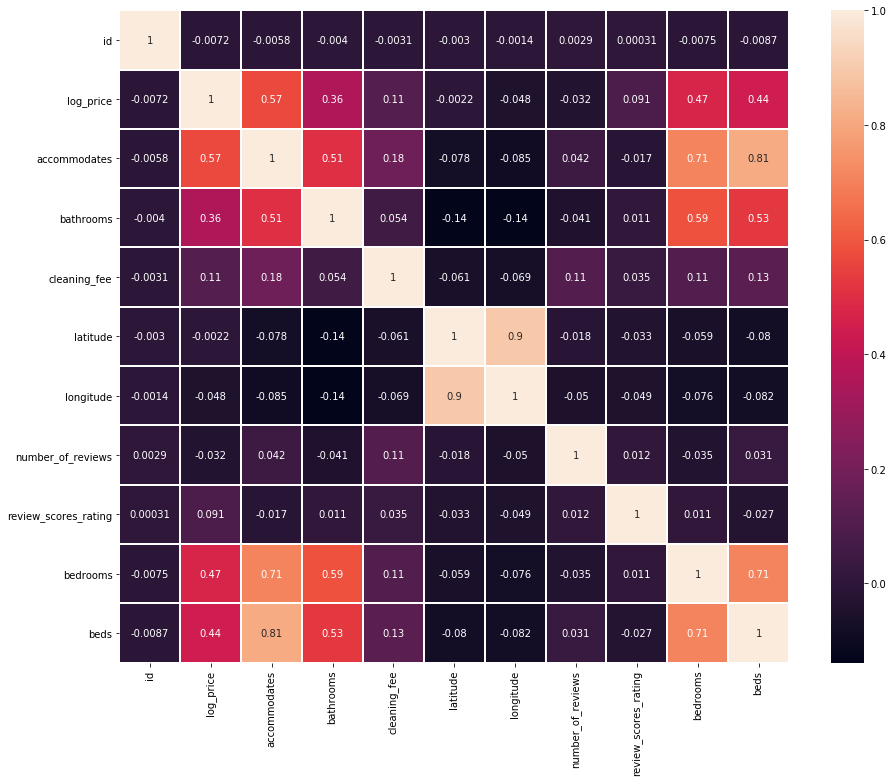

In [6]:
f, ax = plt.subplots( figsize=(15,12) )
sns.heatmap(prices_df.corr(),annot=True,linewidths=1)
plt.show()

In [7]:
prices_df.drop(columns=['id','name','zipcode'],inplace=True,axis=1)

## Missing Values

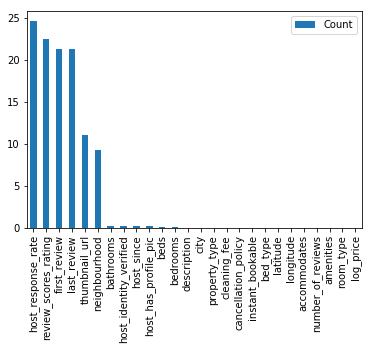

In [8]:
#Dealing with missing values

missing_Count = (prices_df.isnull().sum()/len(prices_df))*100
missing_Count_df = pd.DataFrame({'Col': prices_df.columns, 'Count': missing_Count})
missing_Count_df.sort_values(by='Count',ascending = False, inplace = True)
missing_Count_df.plot.bar()

In [9]:
#Replace the numeric type missing value column with mode

In [10]:
col_numeric = prices_df.select_dtypes(np.number).columns

In [11]:
for col in ['bathrooms','bedrooms','beds']:
    prices_df[col].fillna(prices_df[col].mode()[0],inplace = True)

In [12]:
#Replace the missing values in thumbnail_url to 0 to indicate no file uploaded

prices_df['thumbnail_url'].fillna(value=0,inplace= True)

In [13]:
prices_df.thumbnail_url = prices_df.thumbnail_url.apply(lambda url: 1 if 'http' in str(url) else url)

In [14]:
prices_df['review_scores_rating'].fillna(value= prices_df['review_scores_rating'].mode()[0],inplace = True)

In [15]:
prices_df['host_response_rate'].fillna(value= prices_df['host_response_rate'].mode()[0],inplace = True)
prices_df.host_response_rate = prices_df.host_response_rate.str.strip('%')

In [16]:
prices_df.drop(['first_review','last_review','host_since'],inplace=True,axis=1)

In [17]:
prices_df[['host_identity_verified','host_has_profile_pic']].fillna(value = 'f',axis=1,inplace=True)

In [18]:
prices_df.drop(columns='neighbourhood',axis=1,inplace=True)

In [19]:
prices_df.isnull().sum()

log_price                   0
property_type               0
room_type                   0
amenities                   0
accommodates                0
bathrooms                   0
bed_type                    0
cancellation_policy         0
cleaning_fee                0
city                        0
description                 0
host_has_profile_pic      188
host_identity_verified    188
host_response_rate          0
instant_bookable            0
latitude                    0
longitude                   0
number_of_reviews           0
review_scores_rating        0
thumbnail_url               0
bedrooms                    0
beds                        0
dtype: int64

## Categorical Encoding

In [20]:
colUnique2 = prices_df.columns[prices_df.nunique() ==2]
colUnique2

Index(['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified',
       'instant_bookable', 'thumbnail_url'],
      dtype='object')

In [21]:
pd.get_dummies(prices_df, drop_first=True,columns=colUnique2)
prices_df.drop(axis=1,columns=colUnique2,inplace=True)

In [22]:
##Categorical encoding of rest of the column
colUnique = prices_df.columns[(prices_df.nunique() > 2) & (prices_df.columns.dtype == 'object')]
pd.get_dummies(prices_df,columns=['property_type','room_type','bed_type','cancellation_policy','city'])
prices_df.drop(axis=1,columns=['property_type','room_type','bed_type','cancellation_policy'],inplace=True)

## Feature Engineering

In [23]:
#Feature Engineering: Using latitude and Longitude to create a column calculating distance from Airport

airport_Coordinate = {"Chicago" : (41.9742,87.9073),
                      "DC" :(38.8512,77.0402) ,
                      "LA" : (33.9416,118.4085),
                      "SF" : (37.6213,122.3790),
                      "NYC" : (40.6413,73.7781),
                      "Boston" : (42.3656,71.0096)}

In [24]:
from geopy.distance import great_circle, vincenty

def distance_from_airport(city,lat, lon):
    apartment_spot = (lat, lon)
    return round(vincenty(airport_Coordinate[city], apartment_spot).km, 1)

prices_df["distancefromAirport"] = prices_df.apply(lambda x: distance_from_airport(x.city, x.latitude, x.longitude), axis=1)

In [25]:
prices_df.drop(['latitude','longitude','city'],inplace=True,axis =1)

In [26]:
#One hot encoding of amenities column
amen_df = pd.DataFrame()
amen_df = prices_df['amenities'].str.strip('{}').str.get_dummies(',')

In [27]:
prices_df = pd.concat([prices_df,amen_df],axis = 1)

In [28]:
prices_df.drop(['amenities'],inplace = True,axis=1)

In [29]:
prices_df['description_len'] = prices_df['description'].str.len()
prices_df.drop(['description'],inplace=True,axis=1)

### Checking the dataset before splitting and modelling

In [30]:
prices_df.info

<bound method DataFrame.info of        log_price  accommodates  bathrooms host_response_rate  \
0       5.010635             3        1.0                100   
1       5.129899             7        1.0                100   
2       4.976734             5        1.0                100   
3       6.620073             4        1.0                100   
4       4.744932             2        1.0                100   
5       4.442651             2        1.0                100   
6       4.418841             3        1.0                100   
7       4.787492             2        1.0                100   
8       4.787492             2        1.0                100   
9       3.583519             2        1.0                100   
10      4.605170             2        1.0                100   
11      5.010635             4        1.5                100   
12      4.248495             2        1.0                100   
13      5.298317             6        1.5                100   
14      

In [31]:
prices_df.astype(np.float64)

,log_price,accommodates,bathrooms,host_response_rate,number_of_reviews,review_scores_rating,bedrooms,beds,distancefromAirport,"smooth pathway to front door""",...,Oven,Pool,Refrigerator,Shampoo,Smartlock,Stove,TV,Washer,Waterfront,description_len
0,5.010635,3.0,1.0,100.0,2.0,100.0,1.0,1.0,10427.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,211.0
1,5.129899,7.0,1.0,100.0,6.0,93.0,3.0,3.0,10420.2,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1000.0
2,4.976734,5.0,1.0,100.0,10.0,92.0,1.0,3.0,10414.4,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1000.0
3,6.620073,4.0,1.0,100.0,0.0,100.0,2.0,2.0,9343.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,468.0
4,4.744932,2.0,1.0,100.0,4.0,40.0,0.0,1.0,10996.3,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,699.0
5,4.442651,2.0,1.0,100.0,3.0,100.0,1.0,1.0,9344.7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1000.0
6,4.418841,3.0,1.0,100.0,15.0,97.0,1.0,1.0,10436.3,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1000.0
7,4.787492,2.0,1.0,100.0,9.0,93.0,1.0,1.0,10444.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1000.0
8,4.787492,2.0,1.0,100.0,159.0,99.0,1.0,1.0,9338.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1000.0
9,3.583519,2.0,1.0,100.0,2.0,90.0,1.0,1.0,10471.7,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1000.0


In [32]:
prices_df.head()

,log_price,accommodates,bathrooms,host_response_rate,number_of_reviews,review_scores_rating,bedrooms,beds,distancefromAirport,"smooth pathway to front door""",...,Oven,Pool,Refrigerator,Shampoo,Smartlock,Stove,TV,Washer,Waterfront,description_len
0,5.010635,3,1.0,100,2,100.0,1.0,1.0,10427.4,0,...,0,0,0,0,0,0,0,0,0,211
1,5.129899,7,1.0,100,6,93.0,3.0,3.0,10420.2,0,...,0,0,0,1,0,0,0,1,0,1000
2,4.976734,5,1.0,100,10,92.0,1.0,3.0,10414.4,0,...,0,0,0,1,0,0,1,0,0,1000
3,6.620073,4,1.0,100,0,100.0,2.0,2.0,9343.2,0,...,0,0,0,0,0,0,1,1,0,468
4,4.744932,2,1.0,100,4,40.0,0.0,1.0,10996.3,0,...,0,0,0,1,0,0,1,0,0,699


In [33]:
prices_df.shape

(74111, 140)

In [34]:
prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Columns: 140 entries, log_price to description_len
dtypes: float64(6), int64(133), object(1)
memory usage: 79.2+ MB


## Splitting the dataset

In [35]:
#Import libraries
from sklearn.model_selection import train_test_split

In [36]:
X = prices_df.iloc[:,1:]
y = prices_df.iloc[:,0:1]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [38]:
#Scale Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [39]:
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

### Linear Regression

In [40]:
#Training a LR model
from sklearn.linear_model import LinearRegression
regressor = LinearRegression(n_jobs=-1)
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [41]:
b0 = regressor.intercept_
b1 = regressor.coef_

In [42]:
reshape_regressor_coeff = regressor.coef_.reshape(139,1)
coeff_df = pd.DataFrame(reshape_regressor_coeff, X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
accommodates,3.277073e-01
bathrooms,4.635854e-02
host_response_rate,-6.871923e-03
number_of_reviews,-2.894060e-02
review_scores_rating,7.034102e-02
bedrooms,1.026274e-01
beds,-8.450937e-02
distancefromAirport,-9.766619e-02
"smooth pathway to front door""",-1.390457e+11
"""24-hour check-in""",2.050400e-03


In [43]:
# Predicting the Test set results
y_pred = regressor.predict(X_test)

## Evaluating the model 

In [51]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test,y_pred)
print('MSE: ',mse)
rmse = mse**0.5
print('RMSE: ',rmse)

MSE:  0.28713143376194644
RMSE:  0.5358464647284206
